In [118]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from shapely.ops import transform
import pyproj
import pandas as pd

### load shapefile of water boundaries

In [25]:
# source: https://hub.arcgis.com/datasets/esri::usa-detailed-water-bodies/explore
water_bodies = gpd.read_file("USA_Detailed_Water_Bodies")
water_bodies.head()

,OBJECTID,NAME,FTYPE,FCODE,FCODE_DESC,SQKM,SQMI,geometry
0,1,None,Canal/Ditch,33600,Canal/Ditch,0.13,0.05,"POLYGON ((-157.82567 21.28291, -157.82560 21.2..."
1,2,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-158.02294 21.36398, -158.02338 21.3..."
2,3,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-158.03806 21.36422, -158.03813 21.3..."
3,4,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-158.03420 21.34921, -158.03395 21.3..."
4,5,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.39,0.15,"POLYGON ((-157.73039 21.38151, -157.73041 21.3..."


In [141]:
# reproject so 1 unit = 1 meter
water_bodies = water_bodies.to_crs(epsg=32633)

### limit and reproject

In [142]:
gdf = water_bodies.head(10)

gdf

,OBJECTID,NAME,FTYPE,FCODE,FCODE_DESC,SQKM,SQMI,geometry
0,1,None,Canal/Ditch,33600,Canal/Ditch,0.13,0.05,"POLYGON ((-245650.263 17625464.593, -245659.17..."
1,2,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-224669.273 17617370.004, -224617.26..."
2,3,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-223092.548 17617413.663, -223087.68..."
3,4,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-223569.302 17619066.034, -223595.40..."
4,5,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.39,0.15,"POLYGON ((-255083.299 17614029.764, -255081.57..."
5,6,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.22,0.08,"POLYGON ((-247391.092 17616905.355, -247498.14..."
6,7,None,Lake/Pond,39001,Lake/Pond: Hydrographic Category = Intermittent,0.10,0.04,"POLYGON ((-234239.495 17617838.647, -234023.34..."
7,8,Salt Lake,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.68,0.26,"POLYGON ((-237225.958 17618790.722, -237123.92..."
8,9,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.03,0.01,"POLYGON ((-229620.678 17621731.252, -229620.56..."
9,10,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.08,0.03,"POLYGON ((-259161.660 17623331.399, -259190.26..."


In [143]:
def create_grid(polygon, grid_size=10, crs=32633):
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    rows = int(np.ceil((maxy - miny) / grid_size))
    cols = int(np.ceil((maxx - minx) / grid_size))

    grid_cells = []

    # Create a grid of squares with side length of grid size
    for i in range(cols):
        for j in range(rows):
            # Create the bounding box for each grid square
            x0 = minx + i * grid_size
            y0 = miny + j * grid_size
            x1 = x0 + grid_size
            y1 = y0 + grid_size
            grid_square = box(x0, y0, x1, y1)
            grid_cells.append(grid_square)

    # Create a GeoDataFrame with grid cells in the same CRS as the polygon
    grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=crs)

    # Filter the grid cells that intersect with the polygon
    grid_gdf = grid_gdf[grid_gdf.intersects(polygon)]

    # Find centroid of each grid cell
    grid_gdf["centroid"] = grid_gdf.geometry.centroid

    return grid_gdf

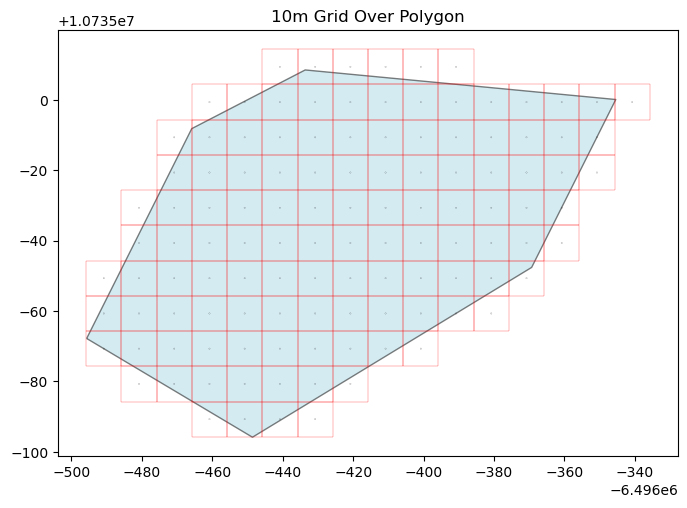

In [151]:
# choose a polygon
# poly = gdf.geometry.values[9]
poly = water_bodies.sort_values("SQKM").geometry.values[0]

grid_gdf = create_grid(poly)

# Plot the grid and the polygon
fig, ax = plt.subplots(figsize=(8, 8))

# plot polygon, grid cells, and centroids
gpd.GeoSeries(poly).plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5)
grid_gdf.geometry.plot(ax=ax, color="none", edgecolor="red", linewidth=0.2, aspect="equal")
grid_gdf.centroid.plot(
    ax=ax, color="none", edgecolor="black", linewidth=0.1, aspect="equal", markersize=1
)

ax.set_title("10m Grid Over Polygon")
plt.show()

In [145]:
# convert to latitude, longitude

In [146]:
grid_gdf.centroid.to_crs(4326)

2      POINT (-79.96291 36.61824)
3      POINT (-79.96298 36.61824)
4      POINT (-79.96304 36.61823)
12     POINT (-79.96285 36.61830)
13     POINT (-79.96292 36.61830)
                  ...            
152    POINT (-79.96350 36.61889)
161    POINT (-79.96338 36.61896)
162    POINT (-79.96344 36.61895)
163    POINT (-79.96351 36.61894)
174    POINT (-79.96352 36.61900)
Length: 117, dtype: geometry

In [147]:
df = pd.DataFrame(columns=["longitude", "latitude"])

centroids = grid_gdf.centroid.to_crs(4326)

df["longitude"] = centroids.x
df["latitude"] = centroids.y

df

,longitude,latitude
2,-79.962909,36.618243
3,-79.962976,36.618235
4,-79.963042,36.618227
12,-79.962852,36.618305
13,-79.962918,36.618297
...,...,...
152,-79.963501,36.618888
161,-79.963377,36.618957
162,-79.963444,36.618949
163,-79.963511,36.618941


In [148]:
df["date"] = "2024-12-06"
df.to_csv("example_points.csv")